# Сборный проект "HR-аналитика"

**Описание проекта**

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

**У нас будет несколько задач.**
* Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.
* Наша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

**Описание данных**
* id — уникальный идентификатор сотрудника;
* dept — отдел, в котором работает сотрудник;
* level — уровень занимаемой должности;
* workload — уровень загруженности сотрудника;
* employment_years — длительность работы в компании (в годах);
* last_year_promo — показывает, было ли повышение за последний год;
* last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
* supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
* salary — ежемесячная зарплата сотрудника;
* job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

**План работы:**
* Задача 1: Построить модель, которая сможет предсказать уровень удовлетворенности сотрудника на основе данных заказчика.
    * Загрузим данные
    * Выполним предобработку данных
    * Выполним исследовательский анализ данных
    * Проведем корреляционный анализ данных
    * Подготовим данные
    * Обучим модель и проверим ее качество
    * Сделаем выводы
* Задача 2: Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.
    * Загрузим данные
    * Выполним предобработку данных
    * Проведем исследовательский анализ данных
    * Добавим новый входной признак
    * Подготовим данные
    * Обучим модель и проверим ее качество
    * Сделаем выводы
* Подведем общие выводы    

## Загрузим необходимые библиотеки

In [1]:
!pip install -q phik
!pip install -q shap
!pip install scikit-learn
!pip install --upgrade scikit-learn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.metrics import make_scorer
import shap
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

RANDOM_STATE = 42

## Задача 1

### Загрузим данные

In [2]:
try: 
    train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv',sep=',', decimal=';')
    X_test = pd.read_csv('/datasets/test_features.csv',sep=',', decimal=';')
    y_test = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv',sep=',', decimal=';')
except:
    train = pd.read_csv('train_job_satisfaction_rate.csv',sep=',', decimal=';')
    X_test = pd.read_csv('test_features.csv',sep=',', decimal=';')
    y_test = pd.read_csv('test_target_job_satisfaction_rate.csv',sep=',', decimal=';')

Просмотрим данные

In [3]:
def df_info(df): #Создадим функцию, которая позволит просмотреть информацию о данных
    display(df.head())
    print('Общая информация')
    display(df.info())
    display(df.describe().T)
    print('Выведем количество пропусков и явных дубликтов')
    display((df.isna().mean() * 100).sort_values(ascending=False))
    print('Количество явных дубликатов:')
    display(df.duplicated().sum())
    display(df.shape)

In [4]:
df_info(train)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.2


Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   3994 non-null   object
 2   level                  3996 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   job_satisfaction_rate  4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

,count,mean,std,min,25%,50%,75%,max
id,4000.0,544957.6210,257883.104622,100954.0,322836.75,534082.5,771446.0,999521.0
employment_years,4000.0,3.7185,2.542513,1.0,2.00,3.0,6.0,10.0
supervisor_evaluation,4000.0,3.4765,1.008812,1.0,3.00,4.0,4.0,5.0
salary,4000.0,33926.7000,14900.703838,12000.0,22800.00,30000.0,43200.0,98400.0


Выведем количество пропусков и явных дубликтов


dept                     0.15
level                    0.10
id                       0.00
workload                 0.00
employment_years         0.00
last_year_promo          0.00
last_year_violations     0.00
supervisor_evaluation    0.00
salary                   0.00
job_satisfaction_rate    0.00
dtype: float64

Количество явных дубликатов:


0

(4000, 10)

In [5]:
df_info(X_test)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.2135,253851.326129,100298.0,339052.0,550793.0,765763.75,999029.0
employment_years,2000.0,3.6665,2.537222,1.0,1.0,3.0,6.00,10.0
supervisor_evaluation,2000.0,3.5265,0.996892,1.0,3.0,4.0,4.00,5.0
salary,2000.0,34066.8000,15398.436729,12000.0,22800.0,30000.0,43200.00,96000.0


Выведем количество пропусков и явных дубликтов


dept                     0.10
level                    0.05
id                       0.00
workload                 0.00
employment_years         0.00
last_year_promo          0.00
last_year_violations     0.00
supervisor_evaluation    0.00
salary                   0.00
dtype: float64

Количество явных дубликатов:


0

(2000, 9)

In [6]:
df_info(y_test)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.6
3,555320,0.72
4,826430,0.08


Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   job_satisfaction_rate  2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.2135,253851.326129,100298.0,339052.0,550793.0,765763.75,999029.0


Выведем количество пропусков и явных дубликтов


id                       0.0
job_satisfaction_rate    0.0
dtype: float64

Количество явных дубликатов:


0

(2000, 2)

**Общий вывод по данным:**
* Датафрейм train:
    * Состоит из 4000 строк и 10 столбцов
    * Явные дубликаты отсутсвуют
    * **Присутствуют пропуски в столбцах dept,level**
    * **Тип данных в столбце job_satisfaction_rate стоит изменить на float64**
* Датафрейм X_test:
    * Состоит из 2000 строк и 9 столбцов
    * Явные дубликаты отсутствуют
    * С типами данных все в порядке
    * **Присутствуют пропуски в столбцах dept,level**
* Датафрейм y_test:
    * Состоит из 2000 строк и 2 столбцов
    * Явные дубликаты отсутствуют
    * Пропуски отсутствуют
    * **Тип данных в столбце job_satisfaction_rate необходимо поменять на float64**
    
    Пропусками займемся на этапе подготовки данных в пайплайне.

### Предобработка данных

Изменим тип данных для всех столбцов

In [7]:
train['job_satisfaction_rate'] = train['job_satisfaction_rate'].astype(float)
y_test['job_satisfaction_rate'] = y_test['job_satisfaction_rate'].astype(float)

Проверим

In [8]:
display(train.info())
display(y_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

Проверим данные на неявные дубликаты

In [9]:
# Список столбцов для отображения уникальных значений
columns_to_display = [
    'dept',
    'level',
    'workload',
    'last_year_promo',
    'last_year_violations'
]
# Создаем функцию для отображения уникальных значений
def display_unique_values(dataframe, columns):
    for column in columns:
        display(dataframe[column].unique())

# Отображаем уникальные значения для train и X_test
display_unique_values(train, columns_to_display)
display_unique_values(X_test, columns_to_display)

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

array(['junior', 'middle', 'sinior', nan], dtype=object)

array(['medium', 'high', 'low'], dtype=object)

array(['no', 'yes'], dtype=object)

array(['no', 'yes'], dtype=object)

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

array(['junior', 'middle', 'sinior', nan], dtype=object)

array(['medium', 'low', 'high', ' '], dtype=object)

array(['no', 'yes'], dtype=object)

array(['no', 'yes'], dtype=object)

Есть ошибка в level, необходимо sinior заменить на senior

In [10]:
train['level'] = train['level'].replace('sinior', 'senior')
X_test['level'] = X_test['level'].replace('sinior', 'senior')
X_test1 = X_test

#### **Общий вывод по предобработке данных:**
* Изменили тип данных для столбца job_satisfaction_rate датафреймов train и X_test
* Проверили данные на неявные дубликаты, их не оказалось
* Оставили пропуски, приняли решения,что работать с ними будем на этапе подготовки данных
* Изменили sinior на senior в столбце level

### Исследовательский анализ данных

Исследуем все признаки и сделаем выводы о том, как их нужно подготовить.

Для начала выделим колличественные и категориальные признаки для каждого из датасетов:
* Датасет train и датасет X_test и y_test
    * Непрерывные колличественные признаки:
        * salary
        * job_satisfaction_rate
    * Дискретные или прерывные колличественные признаки:
        * employment_years
        * supervisor_evaluation
    * Категориальные признаки:
        * dept
        * level
        * workload
        * last_year_promo
        * last_year_violations
 

Начнем с непрерывных колличественных признаков X_test и train

#### Признак salary

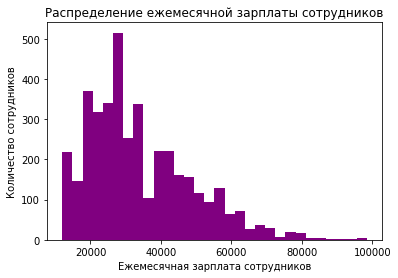

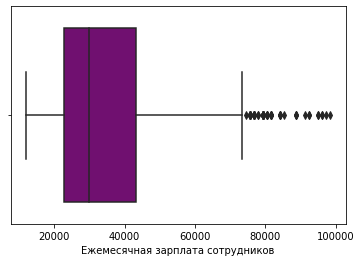

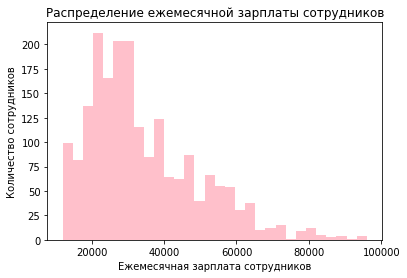

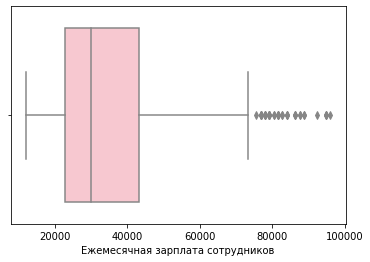

In [11]:
train['salary'].plot(kind='hist',bins = 30,color='purple')
plt.xlabel('Ежемесячная зарплата сотрудников')
plt.ylabel('Количество сотрудников')
plt.title('Распределение ежемесячной зарплаты сотрудников')
plt.show()
sns.boxplot(x=train['salary'], color='purple')
plt.xlabel('Ежемесячная зарплата сотрудников')
plt.show()
X_test['salary'].plot(kind='hist',bins = 30,color='pink')
plt.xlabel('Ежемесячная зарплата сотрудников')
plt.ylabel('Количество сотрудников')
plt.title('Распределение ежемесячной зарплаты сотрудников')
plt.show()
sns.boxplot(x=X_test['salary'], color='pink')
plt.xlabel('Ежемесячная зарплата сотрудников')
plt.show()

В данном признаке, распределение не особо выглядит равномерным, имеется сдвиг в левую сторону, так же есть выбросы , также можно заметить что данные в тренировочном и тестовом датафрейме разные по масштабу, следует учесть при подготовке данных

#### Признак job_satisfaction_rate

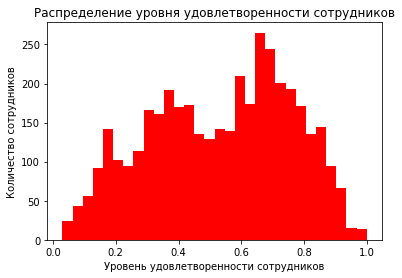

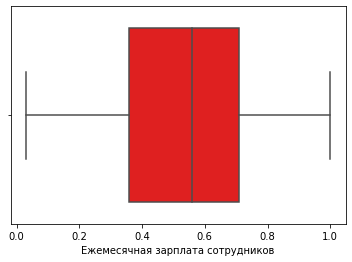

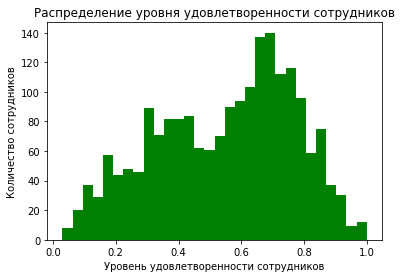

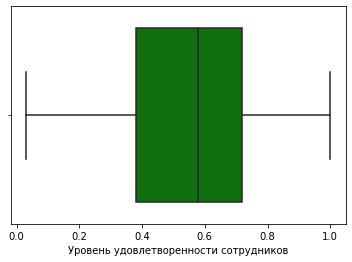

In [12]:
train['job_satisfaction_rate'].plot(kind='hist',bins = 30,color='red')
plt.xlabel('Уровень удовлетворенности сотрудников')
plt.ylabel('Количество сотрудников')
plt.title('Распределение уровня удовлетворенности сотрудников')
plt.show()
sns.boxplot(x=train['job_satisfaction_rate'], color='red')
plt.xlabel('Ежемесячная зарплата сотрудников')
plt.show()
y_test['job_satisfaction_rate'].plot(kind='hist',bins = 30,color='green')
plt.xlabel('Уровень удовлетворенности сотрудников')
plt.ylabel('Количество сотрудников')
plt.title('Распределение уровня удовлетворенности сотрудников')
plt.show()
sns.boxplot(x=y_test['job_satisfaction_rate'], color='green')
plt.xlabel('Уровень удовлетворенности сотрудников')
plt.show()

В датафреймах train и y_test также распределение немного не похоже на нормальное, имеется сдвиг в правую сторону, выбросы отсутствуют, но при этом также заметен разный масштаб,стоит учесть при подготовке данных.

Теперь рассмотрим дискретные колличественные признаки

#### Признак employment_years

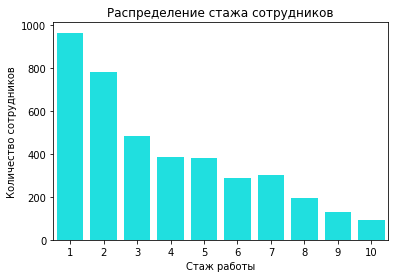

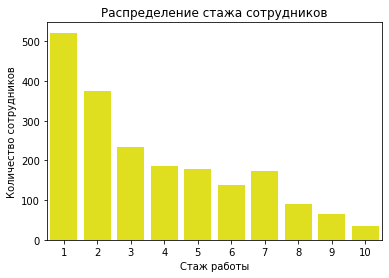

In [13]:
sns.countplot(data=train, x='employment_years', color='cyan')
plt.xlabel('Стаж работы')
plt.ylabel('Количество сотрудников')
plt.title('Распределение стажа сотрудников')
plt.show()
sns.countplot(data=X_test, x='employment_years', color='yellow')
plt.xlabel('Стаж работы')
plt.ylabel('Количество сотрудников')
plt.title('Распределение стажа сотрудников')
plt.show()

В датафреймах train и X_test, данные имеют не равномерное распределение, большинство сотрудников имеют стаж работы год, причем выбросов в данных нет, также заметен опять разный масштаб, стоит учесть при подготовке данных

#### Признак supervisor_evaluation

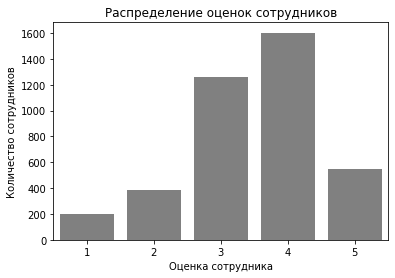

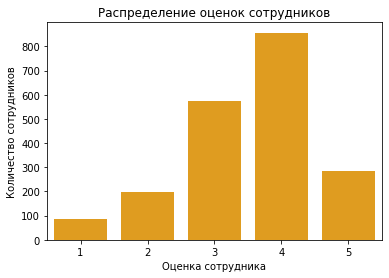

In [14]:
sns.countplot(data=train, x='supervisor_evaluation', color='grey')
plt.xlabel('Оценка сотрудника')
plt.ylabel('Количество сотрудников')
plt.title('Распределение оценок сотрудников')
plt.show()
sns.countplot(data=X_test, x='supervisor_evaluation', color='orange')
plt.xlabel('Оценка сотрудника')
plt.ylabel('Количество сотрудников')
plt.title('Распределение оценок сотрудников')
plt.show()

В датафреймах train и X_test преобладают сотрудники чья работа была оценена на 3 и 4 балла,данные выбросов не имеют, также наблюдается разность масштаба в датафреймах,учтем

#### Категориальные признаки

 Функция для построения круговых диаграмм на основе данных из двух датафреймов

In [15]:
def plot_pie_charts(df, df1, cols, title, ylabel, colors=None):
    for col in cols:
        fig, axes = plt.subplots(1, 2, figsize=(15, 10))

        # Подсчет значений для первого DataFrame
        t1 = df.pivot_table(index=col, values='id', aggfunc='count')
        labels = t1.index.unique()

        # Подсчет значений для второго DataFrame
        t2 = df1.loc[df1[col] != ' '].pivot_table(index=col, values='id', aggfunc='count')

        # Построение первой круговой диаграммы
        axes[0].pie(t1['id'], autopct='%1.0f%%', labels=labels, colors=colors)
        axes[0].set_ylabel(ylabel)
        axes[0].set_title(f"{title} - {col} (train)")

        # Построение второй круговой диаграммы
        axes[1].pie(t2['id'], autopct='%1.0f%%', labels=labels, colors=colors)
        axes[1].set_ylabel(ylabel)
        axes[1].set_title(f"{title} - {col} (X_test)")

        plt.legend(bbox_to_anchor=(1, 0.6))
        plt.tight_layout()  # Автоматическая настройка отступов
        plt.show()


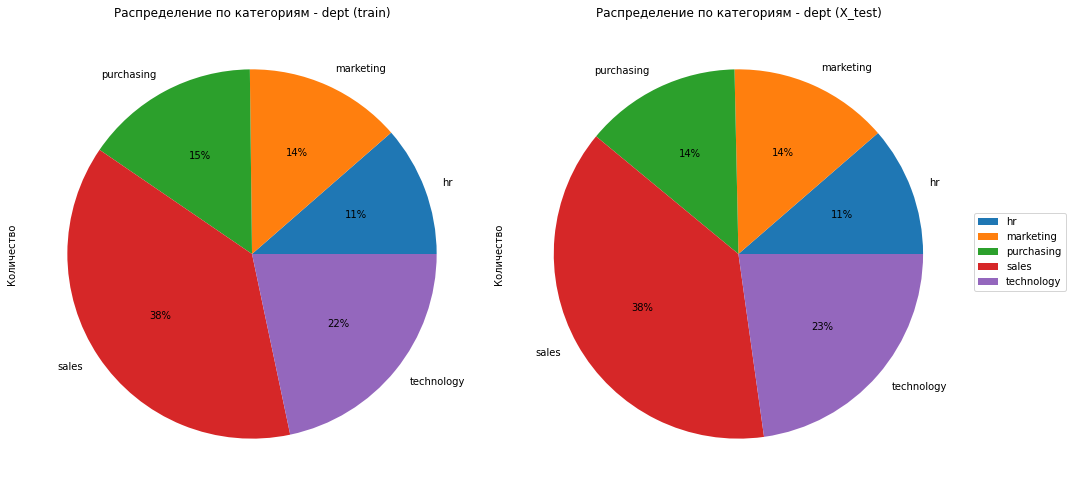

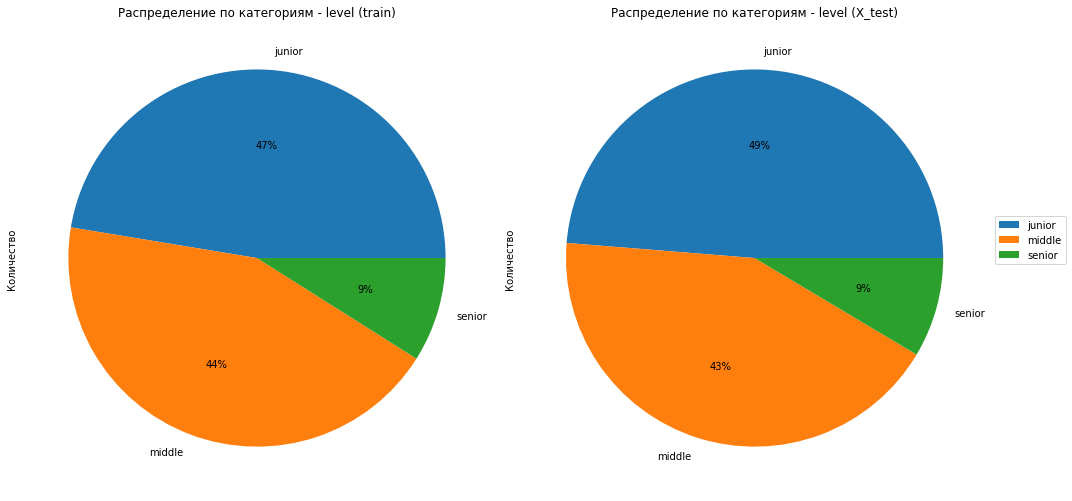

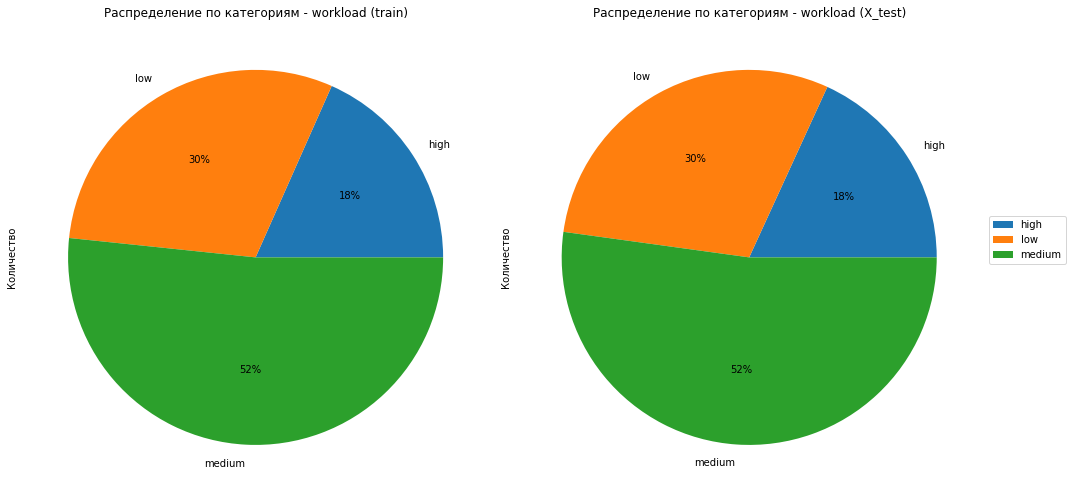

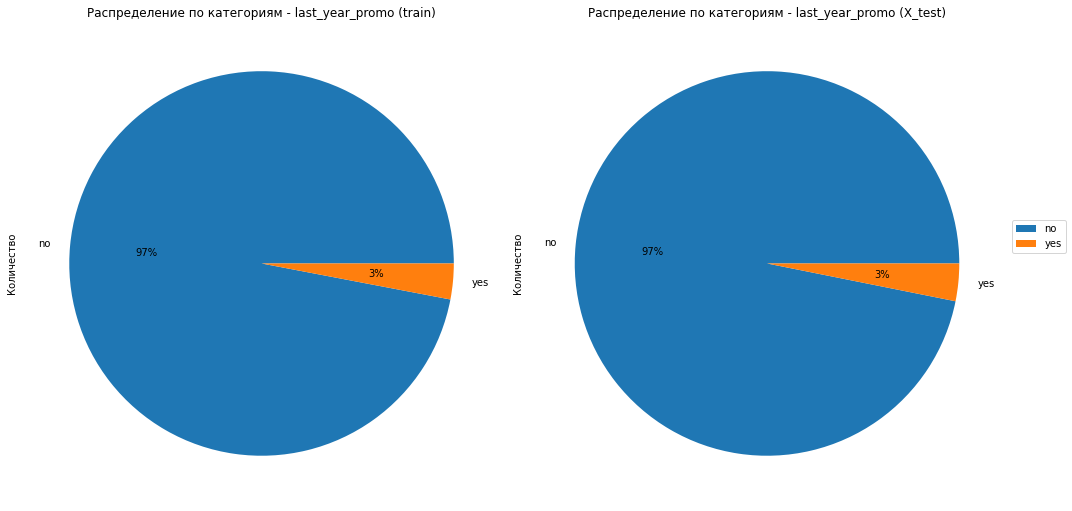

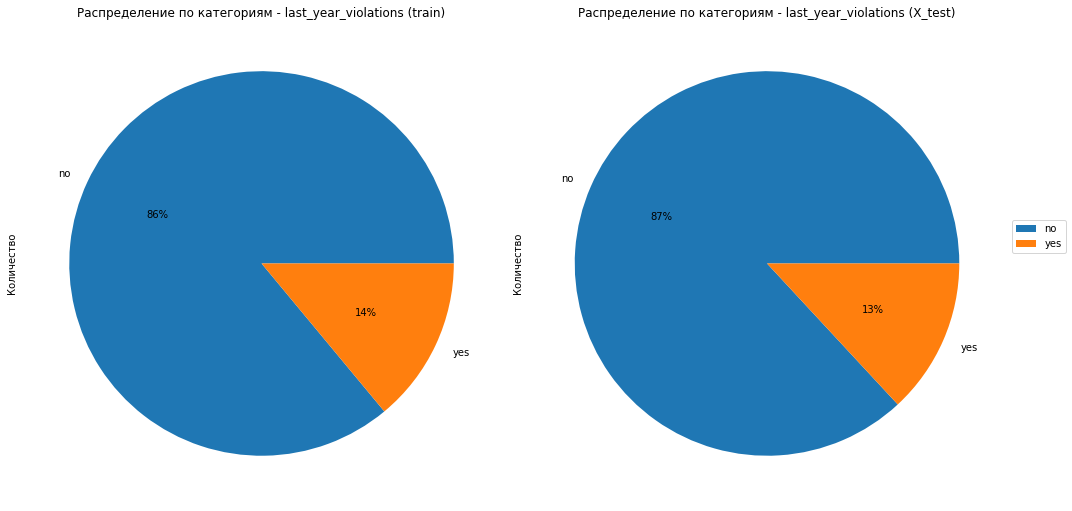

In [16]:
plot_pie_charts(train, X_test, ['dept', 'level','workload','last_year_promo','last_year_violations'],'Распределение по категориям', 'Количество')

Анализ диаграмм показывает, что в компании наибольшее количество сотрудников работает в отделе продаж. Что касается уровней должности, то большинство сотрудников занимают позиции junior и middle. По уровню загруженности наибольшее количество работников имеет среднюю загруженность. Лишь 3% сотрудников получили повышение, в то время как 14% столкнулись с нарушениями трудового договора. Важно отметить, что распределение данных в тренировочной и тестовой выборках практически совпадает.

Для обработки категориальных данных мы планируем использовать различные методы кодирования. Для признаков, связанных с повышениями и нарушениями, будет применяться OneHotEncoder. В то же время, для остальных признаков, таких как уровень должности и уровень загруженности, мы воспользуемся OrdinalEncoder, поскольку эти признаки имеют ранговую природу.

#### **Вывод по исследовательскому анализу данных:**
* Датасет train и датасет X_test и y_test
    *Непрерывные колличественные признаки:
        * salary - В данном признаке, распределение не особо выглядит равномерным, имеется сдвиг в левую сторону, так же есть выбросы , также можно заметить что данные в тренировочном и тестовом датафрейме разные по масштабу, следует учесть при подготовке данных
        * job_satisfaction_rate - В датафреймах train и y_test также распределение немного не похоже на нормальное, имеется сдвиг в правую сторону, выбросы отсутствуют, но при этом также заметен разный масштаб,стоит учесть при подготовке данных.
    * Дискретные или прерывные колличественные признаки:
        * employment_years - В датафреймах train и X_test, данные имеют не равномерное распределение, большинство сотрудников имеют стаж работы год, причем выбросов в данных нет, также заметен опять разный масштаб, стоит учесть при подготовке данных
        * supervisor_evaluation - В датафреймах train и X_test преобладают сотрудники чья работа была оценена на 3 и 4 балла,данные выбросов не имеют, также наблюдается разность масштаба в датафреймах,учтем
    * Категориальные признаки:
        * dept
        * level
        * workload
        * last_year_promo
        * last_year_violations
* Анализ диаграмм показывает, что в компании наибольшее количество сотрудников работает в отделе продаж. Что касается уровней должности, то большинство сотрудников занимают позиции junior и middle. По уровню загруженности наибольшее количество работников имеет среднюю загруженность. Лишь 3% сотрудников получили повышение, в то время как 14% столкнулись с нарушениями трудового договора. Важно отметить, что распределение данных в тренировочной и тестовой выборках практически совпадает.

### Корреляционный анализ данных

In [17]:
data=train.set_index('id')
interval_cols = ['salary', 'job_satisfaction_rate']
phik_overview = phik_matrix(data,interval_cols=interval_cols)

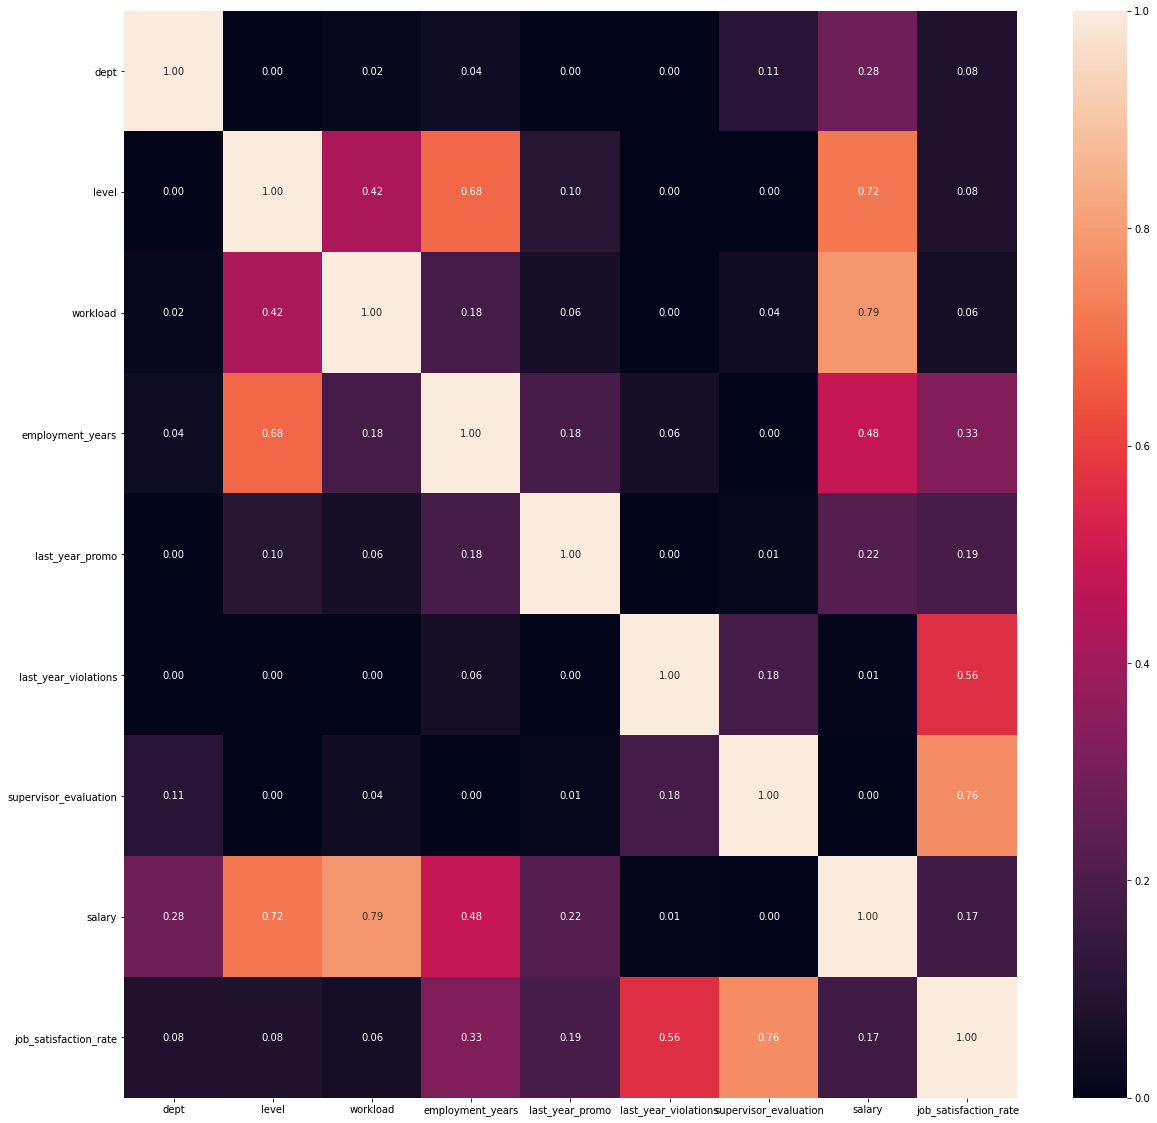

In [18]:
plt.figure(figsize=(20, 20))
# Строим тепловую карту
heatmap = sns.heatmap(data.phik_matrix(interval_cols=interval_cols), annot=True, fmt='.2f')
# Устанавливаем горизонтальные подписи для оси X и y
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=0)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
plt.show()

In [19]:
data_1 = X_test.set_index('id')
interval_cols_1 = ['salary']
phik_overview = phik_matrix(data_1,interval_cols=interval_cols_1)

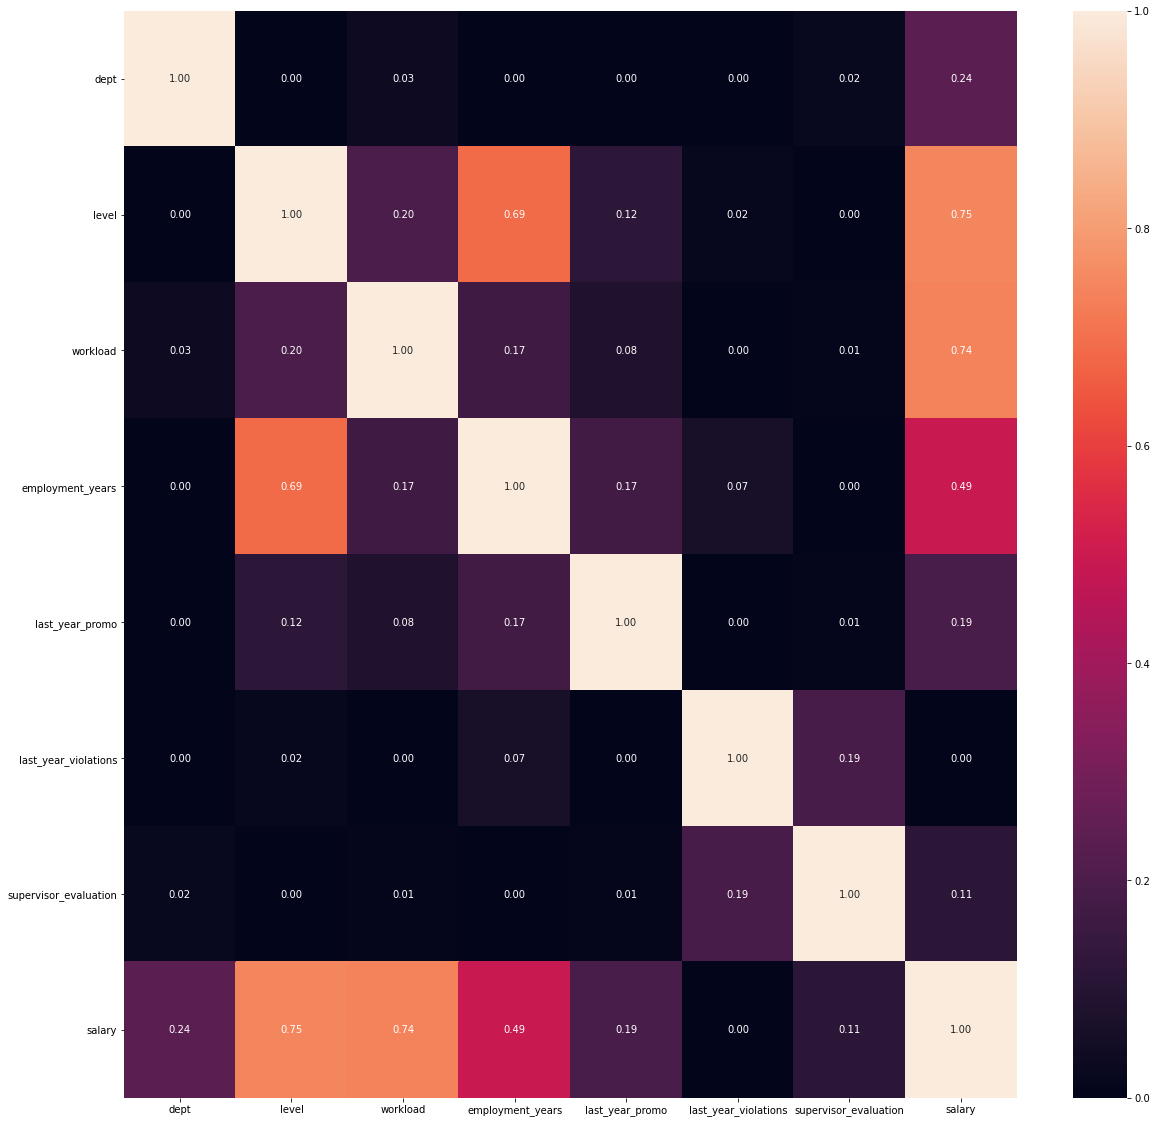

In [20]:
plt.figure(figsize=(20, 20))
# Строим тепловую карту
heatmap_1 = sns.heatmap(data_1.phik_matrix(interval_cols=interval_cols_1), annot=True, fmt='.2f')
# Устанавливаем горизонтальные подписи для оси X и y
heatmap_1.set_xticklabels(heatmap_1.get_xticklabels(), rotation=0)
heatmap_1.set_yticklabels(heatmap_1.get_yticklabels(), rotation=0)
plt.show()

#### **Вывод**
В матрице корреляции видим, что целевой признак значительно коррелирует с тем,нарушал ли сотрудник трудовой договор за последний год,  оценки качества работы сотрудника, которую дал руководитель и длительностью работы в компании,утечки целевого признака нет. Мультиколлинеарность отсутствует. Значения коэффицентов в разных выборках немного отличается, но примерно одинаковы,делаем вывод, что такая ситуация может повлиять на качество модели, но лучше оставить все признаки.

### Подготовка данных

Перейдем к самому главному этап - подготовке данных, вспомним что нужно учесть при подготовке данных:
* Целевой признак - удовлетворенность работника
* Количественные признаки: rоличество лет в компании, оценка работодателя и зарплата нужно масштабировать
* Три признака: отдел, уровень должности и уровень загруженности — нужно кодировать с помощью OrdinalEncoder, причем нужно учесть, что два последних это ранговые признаки
* Два признака: нарушения трудового договора и повышение за последний год — нужно кодировать с помощью OneHotEncoder.

Приступим к подготовке данных

Удалим ненужный признак id, который не связан с целевым признаком, также сразу удалим дубликаты в данных, так как они могут появиться и будут мешать нам.

In [21]:
train_study = train.drop(['id'], axis=1)
print('Количество дубликатов:',train_study.duplicated().sum())

Количество дубликатов: 245


Удалим их

In [22]:
train_study = train_study.drop_duplicates().reset_index(drop=True)
print('Количество дубликатов:',train_study.duplicated().sum())

Количество дубликатов: 0


Для тестовой выборки соединим датафреймы,что данные по целевому признаку шли в том же порядке как и во входных признаках

In [23]:
test = X_test.merge(y_test, on='id')

Теперь создадим выборки

In [24]:
X_train = train_study.drop(['job_satisfaction_rate'], axis=1)
y_train = train_study['job_satisfaction_rate']
X_test_ = test.drop(['job_satisfaction_rate','id'], axis=1)
y_test_ = test['job_satisfaction_rate']
display(X_train.shape)
display(y_train.shape)
display(X_test.shape)
display(y_test.shape)

(3755, 8)

(3755,)

(2000, 9)

(2000, 2)

Займемся пайплайнами для подготовки данных

In [25]:
def pipe(ohe_columns, ord_columns, num_columns):
    global pipe_final
    ohe_pipe = Pipeline(
        [
            (
                'simpleImputer_ohe', 
                SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            ),
            (
                'ohe', 
                OneHotEncoder(drop='first',handle_unknown='ignore')
            )
        ]
    ) 

    ord_pipe = Pipeline(
        [
            (
                'simpleImputer_before_ord', 
                SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            ),
            (
                'ord',  
                OrdinalEncoder(
                    categories=[ 
                        ['junior', 'middle', 'senior'],
                        ['low', 'medium', 'high'],
                    ], 
                    handle_unknown='use_encoded_value', unknown_value=np.nan
                )
            ),
            (
                'simpleImputer_after_ord', 
                SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            )
        ]
    )    

    data_preprocessor = ColumnTransformer(
        [
            ('ohe', ohe_pipe, ohe_columns),
            ('ord', ord_pipe, ord_columns),
            ('num', StandardScaler(), num_columns)
        ], 
        remainder='passthrough'
    )

    pipe_final = Pipeline(
        [
            ('preprocessor', data_preprocessor),
            ('models', LinearRegression())
        ]
    )

In [26]:
ohe_columns = ['last_year_promo','last_year_violations','dept']
ord_columns = ['level', 'workload' ]
num_columns = ['salary', 'employment_years', 'supervisor_evaluation'] 
pipe(ohe_columns, ord_columns, num_columns)

#### **Вывод** 
Подготовили данные, для обучения модели, использовали пайплайны,кодировали, масштабировали, обработка пропусков,данные готовы для использования с моделью

### Обучение модели

Стоит определить, что модели мы будем использовать такие: дерево решений и линейная регрессия. Данный выбор обусловлен типом целевого признака - непрерывный колличественный.
Будем пользоваться поиском оптимальных параметров GridSearch для дерева решений.

Напишем сначала диапозон параметров которые будут перебираться в поиске оптимальных для дерева решений

In [27]:
param_grid = [
    
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 11),
        'models__min_samples_leaf': range(1, 5),
        'models__max_features': range(5, 11)
    },
 
    {
        'models': [LinearRegression()]
    }
]

Для оценки модели будем использовать метрику SMAPE

In [28]:
def smape(y_true, y_pred):
    return 100 * np.mean(np.abs(y_pred - y_true) / ((np.abs(y_pred) + np.abs(y_true))/2))
smape_scorer = make_scorer(smape, greater_is_better=False)

Обучим модель

In [29]:
grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5,
    scoring=smape_scorer,
    n_jobs=-1
)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['last_year_promo',
                                                                          'last_year_violations',
                                                                          'dept']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('simpleImput...
                                                                          'supervisor_evaluation'])])),
                                       ('models', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'models': [DecisionTreeRegressor(random_state=42)],
                          'models__max_depth': range(5, 11),
                          'models__max_features': range(5, 11),
                          'models__min_samples_leaf': range(1, 5)},
                         {'models': [LinearRegression()]}],
             scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

Теперь выберем лучшую модель и посмотрим ее метрику

In [30]:
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid.best_score_*-1)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImput

Метрика на тренировочной выборке уже почти нас устраивает. Чтобы модель была хороша, данная метрика должна показать нам на тестовых данных метрику ниже либо равную 15, перед тем как смотреть метрику на тестовых данных, предлагаю взглянуть на логику действий по поиску лучших гиперпараметров

In [31]:
analysis = pd.DataFrame(grid.cv_results_)
analysis.mean_test_score = analysis.mean_test_score * -1
analysis = analysis[['params','mean_test_score']]
display(analysis.head(10))
display(analysis.tail())

,params,mean_test_score
0,{'models': DecisionTreeRegressor(random_state=...,22.769798
1,{'models': DecisionTreeRegressor(random_state=...,22.842305
2,{'models': DecisionTreeRegressor(random_state=...,22.637358
3,{'models': DecisionTreeRegressor(random_state=...,22.653154
4,{'models': DecisionTreeRegressor(random_state=...,21.312689
5,{'models': DecisionTreeRegressor(random_state=...,21.288427
6,{'models': DecisionTreeRegressor(random_state=...,21.303290
7,{'models': DecisionTreeRegressor(random_state=...,21.363283
8,{'models': DecisionTreeRegressor(random_state=...,20.889651
9,{'models': DecisionTreeRegressor(random_state=...,20.916381


,params,mean_test_score
140,{'models': DecisionTreeRegressor(random_state=...,16.546998
141,{'models': DecisionTreeRegressor(random_state=...,16.252526
142,{'models': DecisionTreeRegressor(random_state=...,16.084729
143,{'models': DecisionTreeRegressor(random_state=...,16.512070
144,{'models': LinearRegression()},25.005621


Видим,что результат линейной регресси хуже чем дерева решений, при этом также можно сделать вывод, что метрика дерева решений улучшается при увеличении глубины.
Теперь просмотрим метрику SMAPE на тестовой выборке

In [32]:
y_pred_test = grid.best_estimator_.predict(X_test_)
smape_test = smape(y_test_, y_pred_test)
print ("Метрика SMAPE равна:", smape_test)

Метрика SMAPE равна: 14.552353588678923


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


#### **Вывод**

Результат метрики удовлетворительный - 14.5, можно использовать модель для дальнейших действий

### **Общий вывод по задаче 1**


В ходе проекта, была создана модель для будущего предсказания удовлетворенности сотрудников.
Также были выполнены шаги:
* Загрузка данных
    * Датафрейм train:
        * Состоит из 4000 строк и 10 столбцов
        * Явные дубликаты отсутсвуют
        * **Присутствуют пропуски в столбцах dept,level**
        * **Тип данных в столбце job_satisfaction_rate стоит изменить на float64**
    * Датафрейм X_test:
        * Состоит из 2000 строк и 9 столбцов
        * Явные дубликаты отсутствуют
        * С типами данных все в порядке
        * **Присутствуют пропуски в столбцах dept,level**
    * Датафрейм y_test:
        * Состоит из 2000 строк и 2 столбцов
        * Явные дубликаты отсутствуют
        * Пропуски отсутствуют
        * **Тип данных в столбце job_satisfaction_rate необходимо поменять на float64**
    * Пропусками займемся на этапе подготовки данных в пайплайне.
* Предобработка данных
    * Изменили тип данных для столбца job_satisfaction_rate датафреймов train и X_test
    * Проверили данные на неявные дубликаты, их не оказалось
    * Оставили пропуски, приняли решения,что работать с ними будем на этапе подготовки данных
    * Изменили sinior на senior в столбце level
* Исследовательский анализ данных
    * Датасет train и датасет X_test и y_test
        *Непрерывные колличественные признаки:
            * salary - В данном признаке, распределение не особо выглядит равномерным, имеется сдвиг в левую сторону, так же есть выбросы , также можно заметить что данные в тренировочном и тестовом датафрейме разные по масштабу, следует учесть при подготовке данных
            * job_satisfaction_rate - В датафреймах train и y_test также распределение немного не похоже на нормальное, имеется сдвиг в правую сторону, выбросы отсутствуют, но при этом также заметен разный масштаб,стоит учесть при подготовке данных.
    * Дискретные или прерывные колличественные признаки:
        * employment_years - В датафреймах train и X_test, данные имеют не равномерное распределение, большинство сотрудников имеют стаж работы год, причем выбросов в данных нет, также заметен опять разный масштаб, стоит учесть при подготовке данных
        * supervisor_evaluation - В датафреймах train и X_test преобладают сотрудники чья работа была оценена на 3 и 4 балла,данные выбросов не имеют, также наблюдается разность масштаба в датафреймах,учтем
    * Категориальные признаки:
        * dept
        * level
        * workload
        * last_year_promo
        * last_year_violations
    * Анализ диаграмм показывает, что в компании наибольшее количество сотрудников работает в отделе продаж. Что касается уровней должности, то большинство сотрудников занимают позиции junior и middle. По уровню загруженности наибольшее количество работников имеет среднюю загруженность. Лишь 3% сотрудников получили повышение, в то время как 14% столкнулись с нарушениями трудового договора. Важно отметить, что распределение данных в тренировочной и тестовой выборках практически совпадает.
* Корреляционный анализ данных
    * В матрице корреляции видим, что целевой признак значительно коррелирует с тем,нарушал ли сотрудник трудовой договор за последний год, оценки качества работы сотрудника, которую дал руководитель и длительностью работы в компании,утечки целевого признака нет. Мультиколлинеарность отсутствует
* Подготовка данных
    * Подготовили данные, для обучения модели, использовали пайплайны,кодировали, масштабировали, обработка пропусков,данные готовы для использования с моделью
* Обучили модель
    * Результат метрики на тестовых данных, удовлетворительный - 14.5, можно использовать модель для дальнейших действий.
    * Лучшей оказалась модель дерева решений с гиперпараметрами: max_depth=10, max_features=10,min_samples_leaf=3, random_state=42

## Задача 2

### Загрузка данных

Также начнем с загрузки данных

In [33]:
try: 
    train_1 = pd.read_csv('/datasets/train_quit.csv',sep=',', decimal=';')
    y_test_1 = pd.read_csv('/datasets/test_target_quit.csv',sep=',', decimal=';')
except:
    train_1 = pd.read_csv('train_quit.csv',sep=',', decimal=';')
    y_test_1 = pd.read_csv('test_target_quit.csv',sep=',', decimal=';')

Просмотрим данные

In [34]:
df_info(train_1)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

,count,mean,std,min,25%,50%,75%,max
id,4000.0,552099.28375,260158.031387,100222.0,327785.75,546673.0,781497.75,999915.0
employment_years,4000.0,3.70150,2.541852,1.0,2.00,3.0,6.00,10.0
supervisor_evaluation,4000.0,3.47475,1.004049,1.0,3.00,4.0,4.00,5.0
salary,4000.0,33805.80000,15152.415163,12000.0,22800.00,30000.0,43200.00,96000.0


Выведем количество пропусков и явных дубликтов


id                       0.0
dept                     0.0
level                    0.0
workload                 0.0
employment_years         0.0
last_year_promo          0.0
last_year_violations     0.0
supervisor_evaluation    0.0
salary                   0.0
quit                     0.0
dtype: float64

Количество явных дубликатов:


0

(4000, 10)

In [35]:
df_info(y_test_1)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.2135,253851.326129,100298.0,339052.0,550793.0,765763.75,999029.0


Выведем количество пропусков и явных дубликтов


id      0.0
quit    0.0
dtype: float64

Количество явных дубликатов:


0

(2000, 2)

**Общий вывод по данным:**
* Датафрейм train_1:
    * Состоит из 4000 строк и 10 столбцов
    * Явные дубликаты отсутствуют
    * Пропуски отсутствуют
    * С названиями столбцов все в порядке
    * C типами данных все в порядке
* Датафрейм y_test_1:
    * Состоит из 2000 строк и 2 столбцов
    * Явные дубликаты отсутствуют
    * Пропуски отсутствуют
    * С названиями столбцов все в порядке
    * Типы данных в норме
Хоть явных проблем с данными нет, стоит провести более подробный анализ

### Предобработка данных

Просмотрим данные на уникальные значения

In [36]:
columns_to_display = [
    'dept',
    'level',
    'workload',
    'last_year_promo',
    'last_year_violations'
]
# Создаем функцию для отображения уникальных значений
def display_unique_values(dataframe, columns):
    for column in columns:
        display(dataframe[column].unique())
# Отображаем уникальные значения для train_1 и y_test_1
display_unique_values(train_1, columns_to_display)
display(y_test_1['quit'].unique())

array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

array(['middle', 'junior', 'sinior'], dtype=object)

array(['high', 'medium', 'low'], dtype=object)

array(['no', 'yes'], dtype=object)

array(['no', 'yes'], dtype=object)

array(['yes', 'no'], dtype=object)

Снова заменим sinior на senior

In [37]:
train_1['level'] = train_1['level'].replace('sinior', 'senior')
train_1['level'].unique()

array(['middle', 'junior', 'senior'], dtype=object)

In [38]:
X_test_1 = X_test

#### **Вывод:**
Заменили грамматическую ошибку, больше никаких действий не делали, так как данные похожи на те же, что и в задании 1

### Исследовательский анализ данных

Для того чтобы проверить похожи ли данные на те, которые были в прошлом задании, посмотрим на распределения колличественных признаков

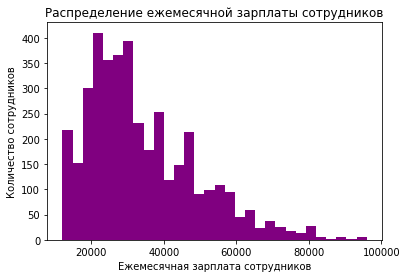

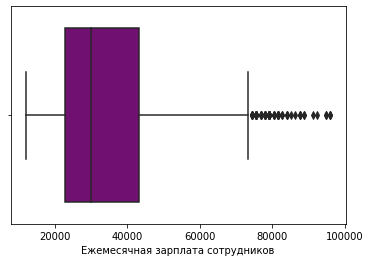

In [39]:
train_1['salary'].plot(kind='hist',bins = 30,color='purple')
plt.xlabel('Ежемесячная зарплата сотрудников')
plt.ylabel('Количество сотрудников')
plt.title('Распределение ежемесячной зарплаты сотрудников')
plt.show()
sns.boxplot(x=train_1['salary'], color='purple')
plt.xlabel('Ежемесячная зарплата сотрудников')
plt.show()

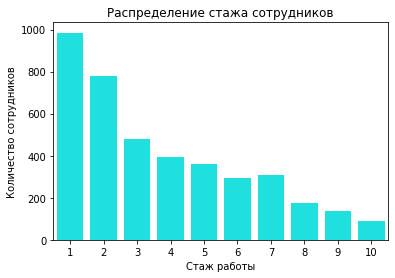

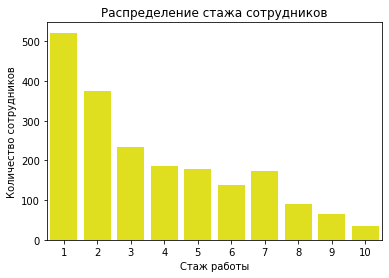

In [40]:
sns.countplot(data=train_1, x='employment_years', color='cyan')
plt.xlabel('Стаж работы')
plt.ylabel('Количество сотрудников')
plt.title('Распределение стажа сотрудников')
plt.show()
sns.countplot(data=X_test, x='employment_years', color='yellow')
plt.xlabel('Стаж работы')
plt.ylabel('Количество сотрудников')
plt.title('Распределение стажа сотрудников')
plt.show()

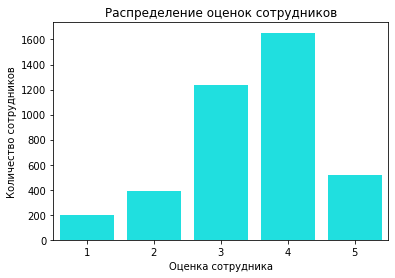

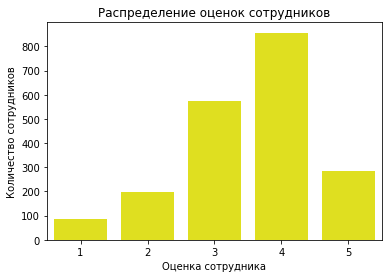

In [41]:
sns.countplot(data=train_1, x='supervisor_evaluation', color='cyan')
plt.xlabel('Оценка сотрудника')
plt.ylabel('Количество сотрудников')
plt.title('Распределение оценок сотрудников')
plt.show()
sns.countplot(data=X_test, x='supervisor_evaluation', color='yellow')
plt.xlabel('Оценка сотрудника')
plt.ylabel('Количество сотрудников')
plt.title('Распределение оценок сотрудников')
plt.show()

Теперь категориальные признаки:

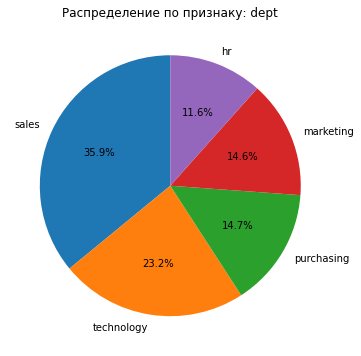

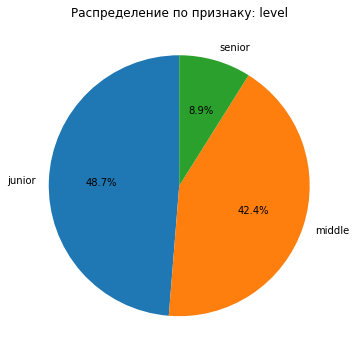

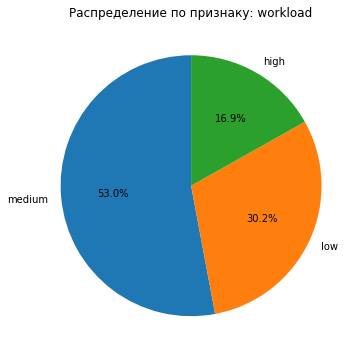

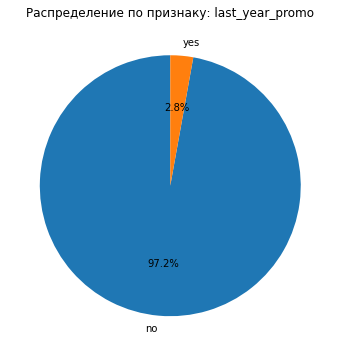

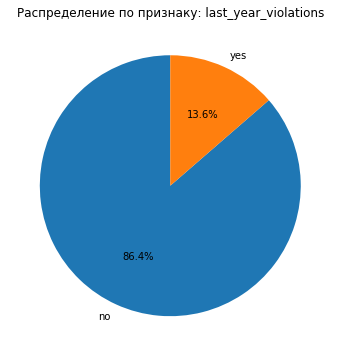

In [42]:
categorical_features = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
for feature in categorical_features:
    plt.figure(figsize=(8, 6))
    train_1[feature].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
    plt.title(f'Распределение по признаку: {feature}')
    plt.ylabel('')  # Убираем метку y
    plt.show()

Как видим, графики идентичные, соответственно, при исследовательском анализе данных,данные признаки можно не рассматривать подробно,так как это было сделано ранее

Теперь стоит просмотреть распределения с новым целевым признаком - quit

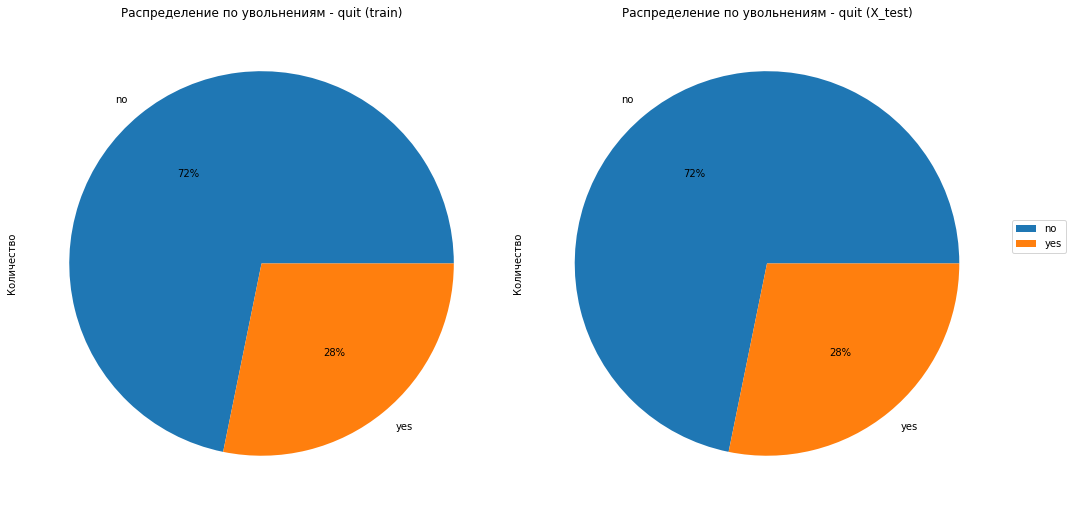

In [43]:
plot_pie_charts(train_1, y_test_1, ['quit'],'Распределение по увольнениям', 'Количество')

**Вывод:**

Получается, что уволенных сотрудников 28% от общего количества сотрудников,для дальнейшего анализа и составления модели,стоит понимать каков потрет уволенного сотрудника. Стоит отметить, что распределения в данных такие же как и распределения в данных прошлой задачи, поэтому все сделанные ранее выводы применимы и к этим данным

#### Составление портрета уволенного сотрудника

Для начала стоит вывести соотношение уволивишхся и работающих сотрудников 

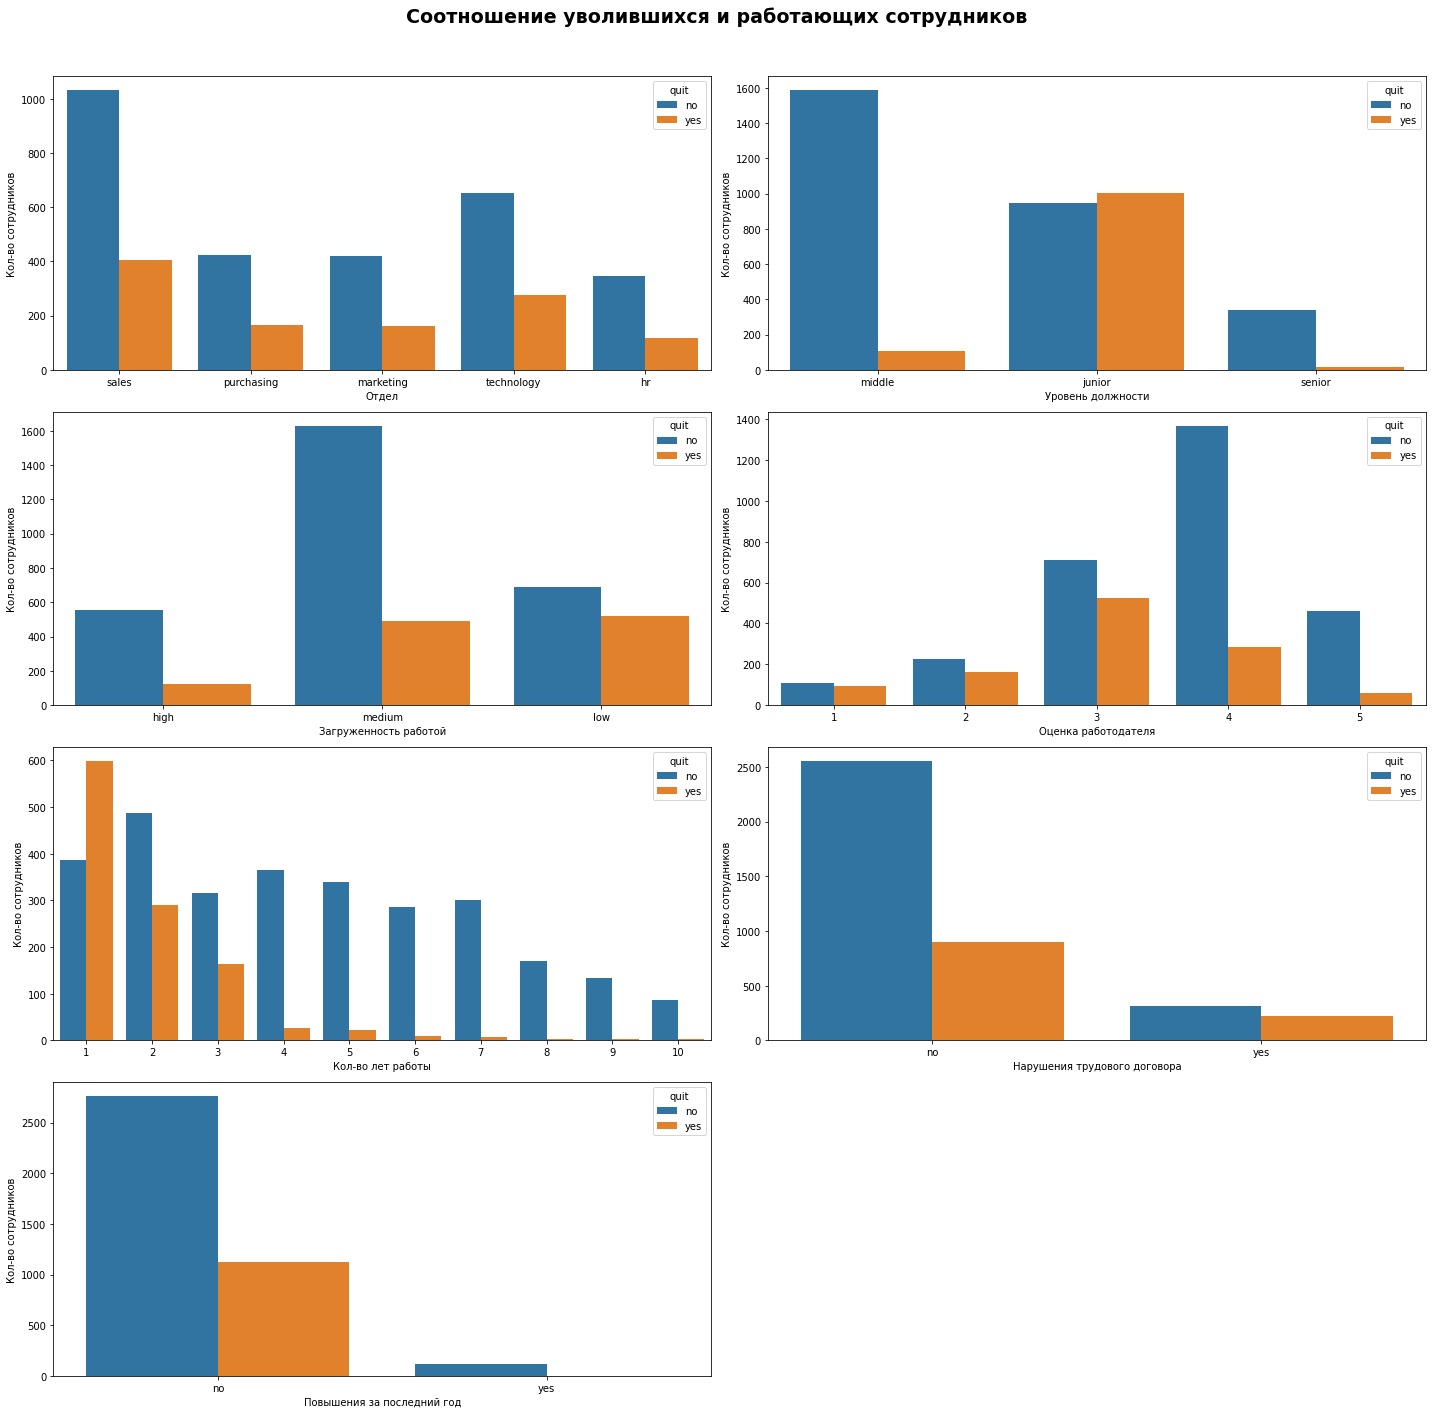

In [44]:
# Данные для графиков
columns = [
    ('dept', 'Отдел'),
    ('level', 'Уровень должности'),
    ('workload', 'Загруженность работой'),
    ('supervisor_evaluation', 'Оценка работодателя'),
    ('employment_years', 'Кол-во лет работы'),
    ('last_year_violations', 'Нарушения трудового договора'),
    ('last_year_promo', 'Повышения за последний год')
]
# Создание подграфиков
fig, axes = plt.subplots(4, 2, figsize=(20, 20))
plt.suptitle('Соотношение уволившихся и работающих сотрудников', fontsize=19, fontweight='bold')

# Построение графиков
for ax, (col, xlabel) in zip(axes.flatten(), columns):
    sns.countplot(x=col, data=train_1, hue='quit', ax=ax)
    ax.set(xlabel=xlabel, ylabel='Кол-во сотрудников')
    # Удаляем лишний подграфик
if len(columns) < len(axes.flatten()):
    fig.delaxes(axes.flatten()[len(columns)])
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Теперь для полного портрета просмотрим соотношение ЗП

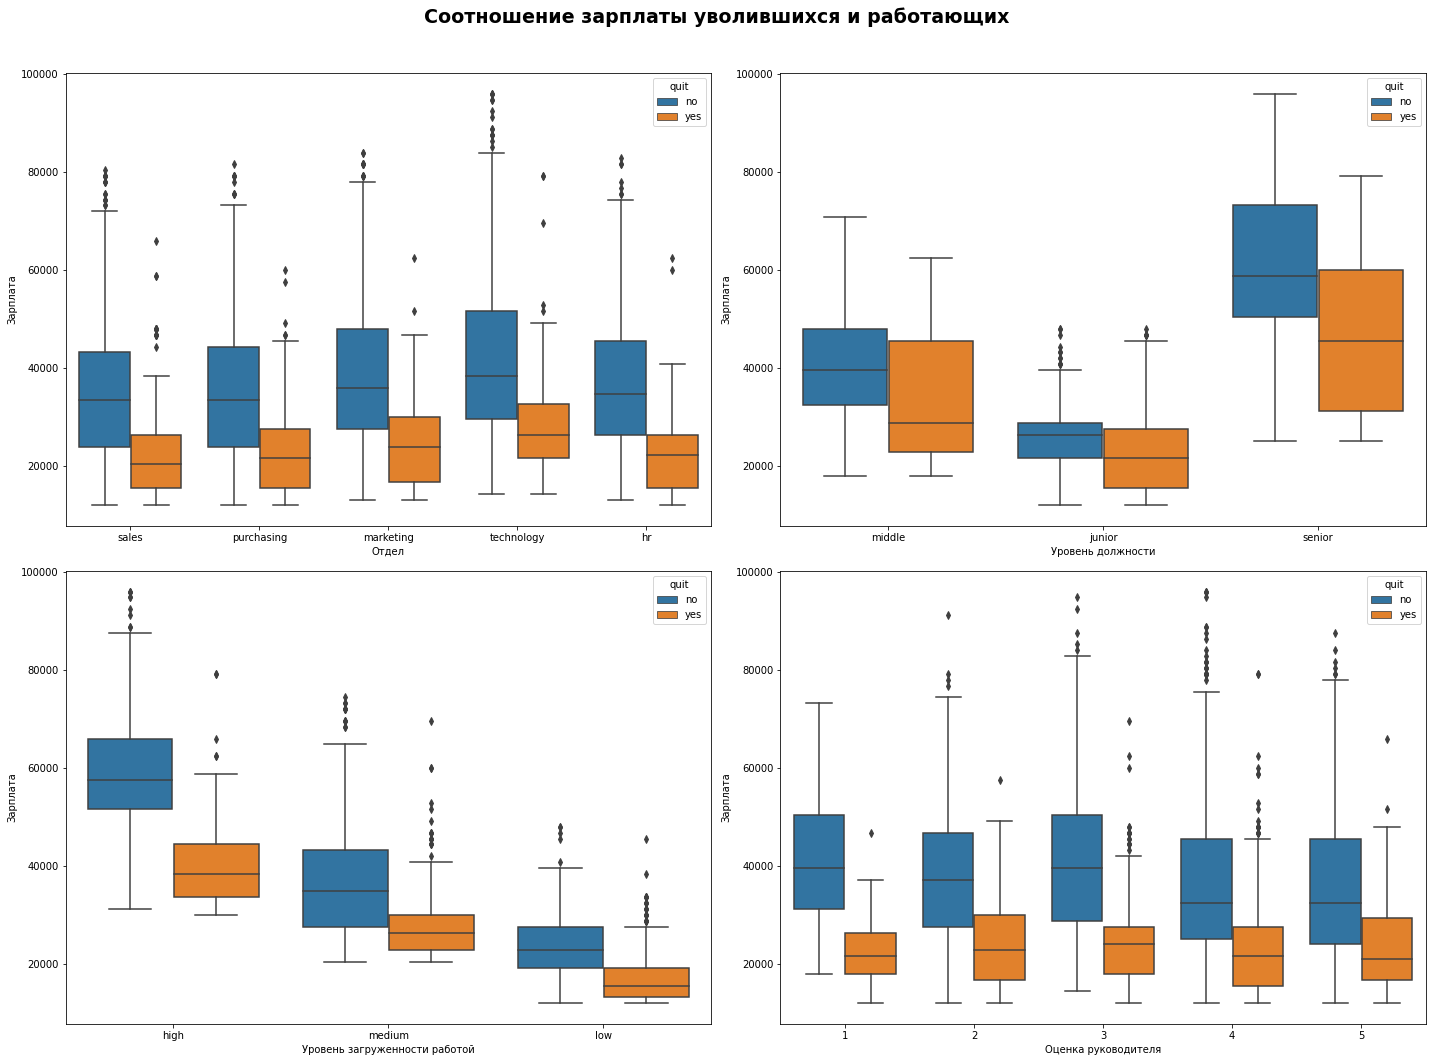

In [45]:
# Данные для графиков
columns = [
    ('dept', 'Отдел'),
    ('level', 'Уровень должности'),
    ('workload', 'Уровень загруженности работой'),
    ('supervisor_evaluation', 'Оценка руководителя')
]
# Создание подграфиков
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
plt.suptitle('Соотношение зарплаты уволившихся и работающих', fontsize=19, fontweight='bold')
# Построение графиков
for ax, (col, xlabel) in zip(axes.flatten(), columns):
    sns.boxplot(x=col, y='salary', hue='quit', data=train_1, ax=ax)
    ax.set(xlabel=xlabel, ylabel='Зарплата')
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

Анализ категориальных признаков

In [46]:
for col, xlabel in columns:
    relative_counts = train_1[col].value_counts(normalize=True).reset_index()
    relative_counts.columns = [xlabel, 'Доля']
    print(relative_counts)

        Отдел    Доля
0       sales  0.3595
1  technology  0.2320
2  purchasing  0.1470
3   marketing  0.1455
4          hr  0.1160
  Уровень должности     Доля
0            junior  0.48725
1            middle  0.42350
2            senior  0.08925
  Уровень загруженности работой    Доля
0                        medium  0.5295
1                           low  0.3020
2                          high  0.1685
   Оценка руководителя     Доля
0                    4  0.41350
1                    3  0.30825
2                    5  0.13000
3                    2  0.09775
4                    1  0.05050


Выведем средние значения зарплаты уволившихся и не уволившихся сотрудников

In [47]:
salary_comparison = train_1.groupby('quit')['salary'].mean().reset_index()
salary_comparison.columns = ['Уволились', 'Средняя зарплата']
print(salary_comparison)

  Уволились  Средняя зарплата
0        no      37702.228412
1       yes      23885.106383


Теперь визуализируем

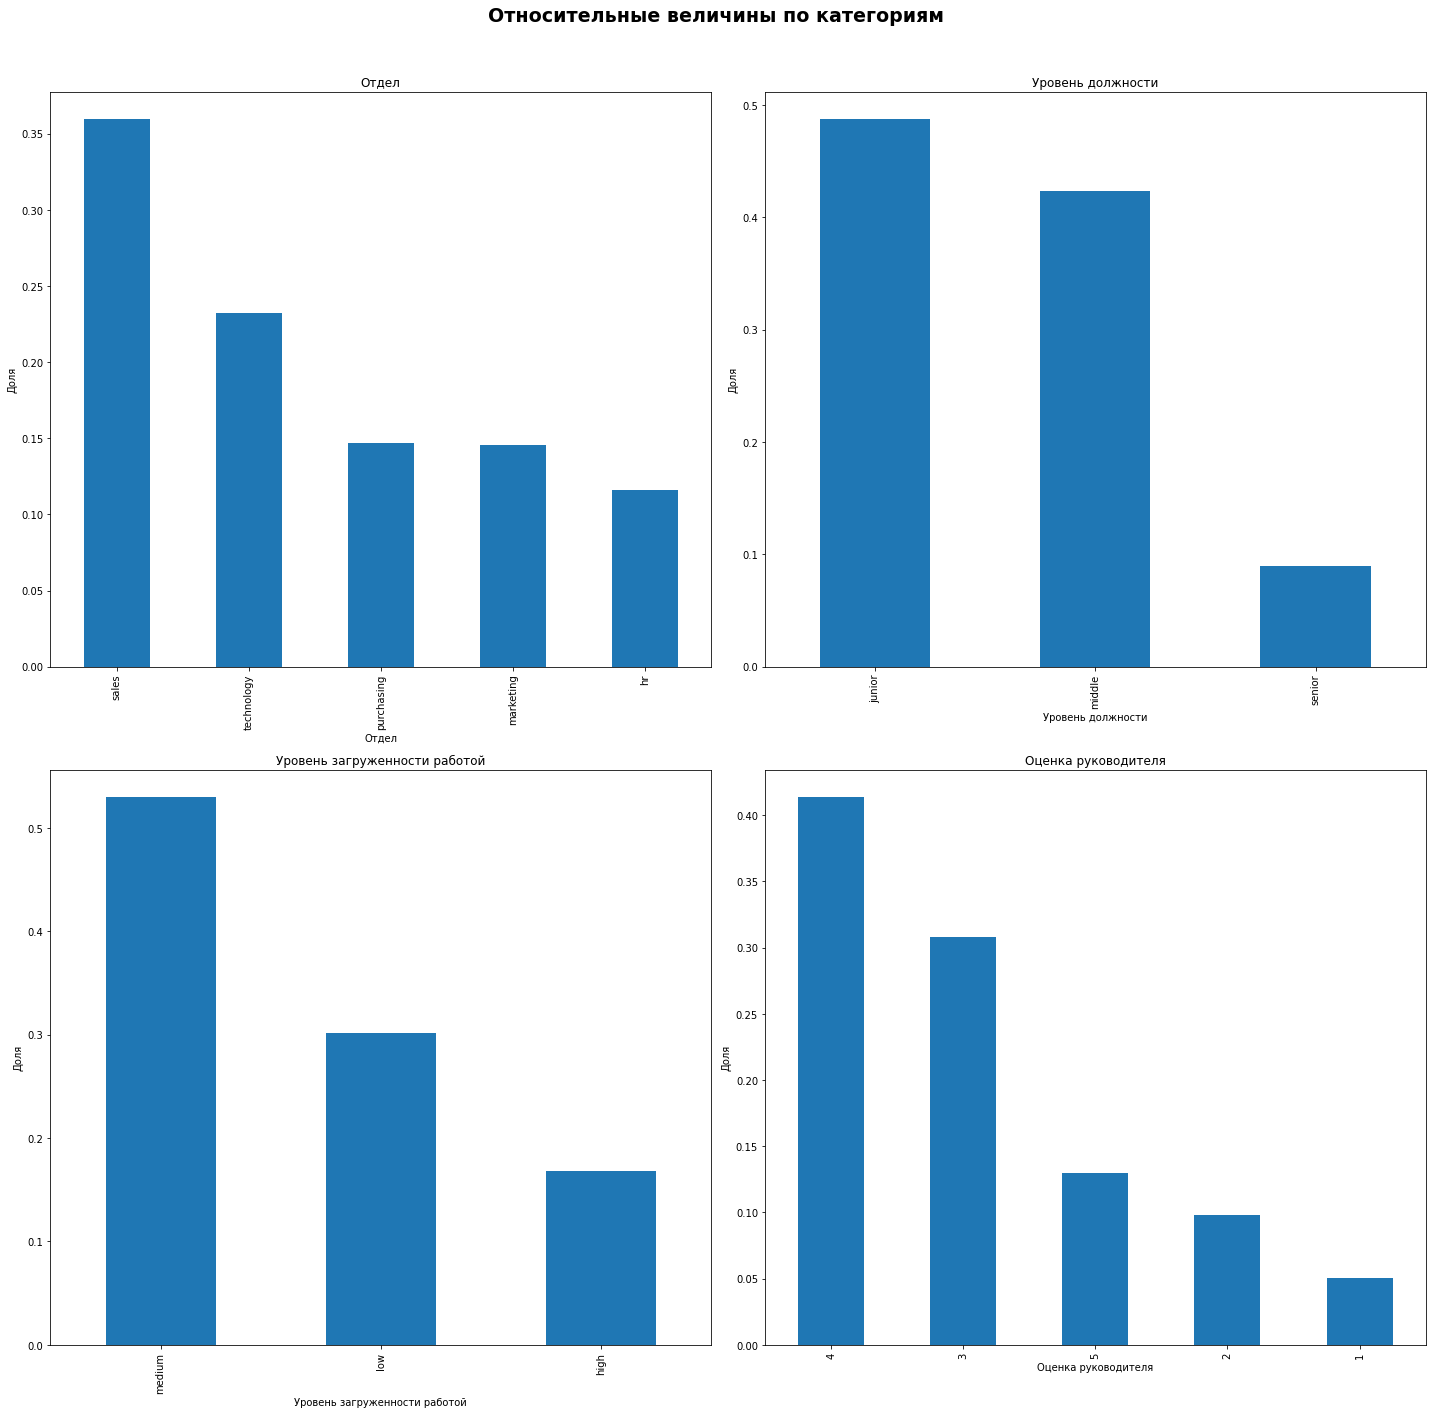

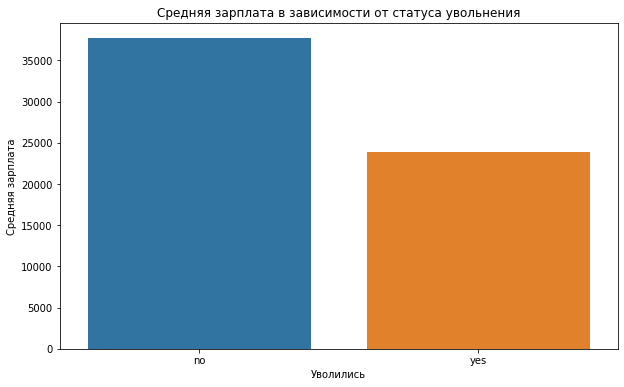

In [48]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
plt.suptitle('Относительные величины по категориям', fontsize=19, fontweight='bold')

for ax, (col, xlabel) in zip(axes.flatten(), columns):
    relative_counts = train_1[col].value_counts(normalize=True)
    relative_counts.plot(kind='bar', ax=ax)
    ax.set_title(xlabel)
    ax.set_ylabel('Доля')
    ax.set_xlabel(xlabel)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
# Визуализация средних значений зарплаты
plt.figure(figsize=(10, 6))
sns.barplot(x='Уволились', y='Средняя зарплата', data=salary_comparison)
plt.title('Средняя зарплата в зависимости от статуса увольнения')
plt.ylabel('Средняя зарплата')
plt.xlabel('Уволились')
plt.show()

In [49]:
categorical_columns = ['dept','level','workload','last_year_promo','last_year_violations'] 
# Для каждого категориального признака выводим относительные величины
for col in categorical_columns:
    relative_counts = train_1[col].value_counts(normalize=True)
    print(f"Относительные величины для {col}:\n{relative_counts}\n")
# Анализ зарплат в разрезе статуса увольнения
salary_analysis = train_1.groupby('quit')['salary'].agg(['mean', 'count']).reset_index()
salary_analysis.columns = ['quit', 'average_salary', 'count']
print("Средние зарплаты в разрезе статуса увольнения:\n", salary_analysis)

Относительные величины для dept:
sales         0.3595
technology    0.2320
purchasing    0.1470
marketing     0.1455
hr            0.1160
Name: dept, dtype: float64

Относительные величины для level:
junior    0.48725
middle    0.42350
senior    0.08925
Name: level, dtype: float64

Относительные величины для workload:
medium    0.5295
low       0.3020
high      0.1685
Name: workload, dtype: float64

Относительные величины для last_year_promo:
no     0.97175
yes    0.02825
Name: last_year_promo, dtype: float64

Относительные величины для last_year_violations:
no     0.86375
yes    0.13625
Name: last_year_violations, dtype: float64

Средние зарплаты в разрезе статуса увольнения:
   quit  average_salary  count
0   no    37702.228412   2872
1  yes    23885.106383   1128


**Вывод:**
Смотря на графики можем выявить, что:
Большинство уволенных работников работали в отделе продаж, но на самом деле во всех отделах достаточно уволенных рабочих, имели должность junior, имели низкую загрузку на работе, при этом оценка от руководителя была - 3, сотрудник работал 1 год и не нарушал условия трудового договора. При этом сравнивая ЗП, мы видим, что средние зарплаты уволившихся сотрудников в сравнении с продолжающими работать ниже, причем во всех категориях (во всех отделах, во всех уровнях загруженности, во всех уровнях должности, со всеми оценками работодателя. 
Общий портрет уволенного сотрудника:
Работник,не загруженный работой, junior, имеющий низкую зарплату,чью работу не особо хорошо оценивает руководитель и имеющий стаж 1 год - типичный начинающий специалист

#### Проверка утверждения

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это утверждение: визуализируем и сравним распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Будем использовать данные с обоими целевыми признаками тестовой выборки.

Для проверки нам необходимо сначала добавить признак в тестовую выборку

In [50]:
data_1=y_test.merge(y_test_1, on='id')
data_1=data_1.set_index('id')

Чтобы проверить зависимость построим матрицу корреляции

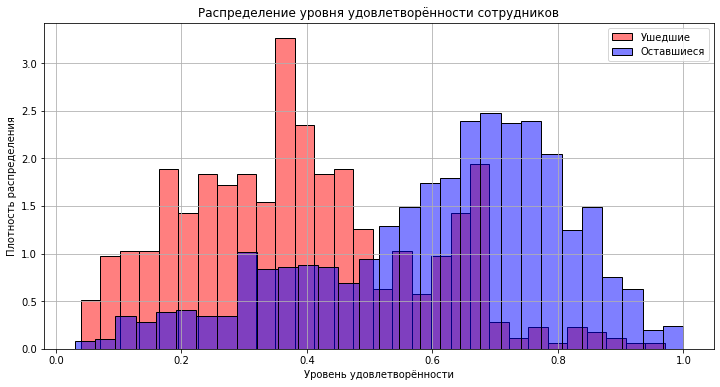

In [51]:
# Визуализация распределения уровня удовлетворённости
plt.figure(figsize=(12, 6))
# Нормированная гистограмма для ушедших сотрудников
sns.histplot(data=data_1[data_1['quit'] == 'yes'], 
             x='job_satisfaction_rate', 
             stat='density', 
             common_norm=False, 
             color='red', 
             label='Ушедшие', 
             bins=30, 
             alpha=0.5)

# Нормированная гистограмма для оставшихся сотрудников
sns.histplot(data=data_1[data_1['quit'] == 'no'], 
             x='job_satisfaction_rate', 
             stat='density', 
             common_norm=False, 
             color='blue', 
             label='Оставшиеся', 
             bins=30, 
             alpha=0.5)

# Добавление легенды и заголовка
plt.legend()
plt.title('Распределение уровня удовлетворённости сотрудников')
plt.xlabel('Уровень удовлетворённости')
plt.ylabel('Плотность распределения')
plt.grid()
plt.show()

Вывод:
* График показывает два пика для «Ушедших» между 0.2 и 0.4, а также между 0.6 и 0.8.
Для «Оставшихся» пик наблюдается в диапазоне 0.6 и 0.8, что указывает на более высокий уровень удовлетворённости.
* Ушедшие» имеют более выраженные пики в низкой и средней области удовлетворённости.
«Оставшиеся» сосредоточены в области высокой удовлетворённости (ближе к 0.8 и 1.0).
* У сотрудников, которые ушли, уровень удовлетворённости, кажется, был ниже по сравнению с теми, кто остался.
Возможно, это указывает на взаимосвязь между уровнем удовлетворённости и решением сотрудников остаться или уйти из компании.

#### Добавим новый признак

Добавим признак удовлетворенности работой в наши выборки: тестовую и тренировочную. Будем использовать лучшую модель из 1 задачи, получим предсказания удовлетворенности и добавим в виде дополнительного столбца в тестовую и тренировочную выборки

Удалим столбец id

In [52]:
X_test = X_test.drop(X_test.columns[0],axis=1)
train_1 = train_1.drop(train_1.columns[0],axis=1)

Теперь добавим новый столбец в тестовую выборку

In [53]:
X_test_1['job_satisfaction_rate_pred'] = grid.best_estimator_.predict(X_test)
X_test_1.head()

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_pred
0,485046,marketing,junior,medium,2,no,no,5,28800,0.837297
1,686555,hr,junior,medium,1,no,no,4,30000,0.678776
2,467458,sales,middle,low,5,no,no,4,19200,0.663043
3,418655,sales,middle,low,6,no,no,4,19200,0.663043
4,789145,hr,middle,medium,5,no,no,5,40800,0.807978


А теперь в тренировочную

In [54]:
train_1['job_satisfaction_rate_pred'] = grid.best_estimator_.predict(train_1.drop(['quit'], axis=1))
train_1.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
0,sales,middle,high,2,no,no,4,54000,no,0.620916
1,sales,junior,medium,2,no,no,4,27600,no,0.837297
2,purchasing,middle,medium,5,no,no,1,37200,no,0.402143
3,sales,junior,medium,2,no,yes,3,24000,yes,0.334286
4,marketing,junior,medium,2,no,no,5,25200,no,0.813636


#### **Вывод**
* Провели исследовательский анализ данных: общий портрет уволенного сотрудника: Работник,не загруженный работой, junior, имеющий низкую зарплату,чью работу не особо хорошо оценивает руководитель и имеющий стаж 1 год - типичный начинающий специалист
* Утверждение подтвердилось, признак удовлетворенности сотрудника имеет зависимость с признаком уволенности, коэффицент корреляции равен 0.61, для дальнейшего обучения модели, необходимо учитывать этот признак.
* Добавили новый признак в тестовую и тренировочную выборки

### Подготовка данных

Подготовка данных будет проходить аналогично первой задаче, только к масштабированию количественных признаков добавится новый признак - удовлетворенность работой

Стоит снова удалить дубликаты в данных, дабы они были чище

In [55]:
train_1 = train_1.drop_duplicates().reset_index(drop=True)
print('Количество дубликатов:',train_1.duplicated().sum())

Количество дубликатов: 0


In [56]:
X_train_1 = train_1.drop(['quit'], axis=1)
y_train_1 = train_1['quit']
test_1 = X_test_1.merge(y_test_1, on='id')
X_test_1_ = test_1.drop(['quit','id'], axis=1)
y_test_1_ = test_1['quit']
display(X_test_1_.shape)
display(X_train_1.shape)

(2000, 9)

(2587, 9)

Так как у нас целевой признак теперь категориальный,его надо тоже кодировать - методом LabelEncoder.

In [57]:
label_encoder = LabelEncoder()
y_train1 = label_encoder.fit_transform(y_train_1)
y_test1_ = label_encoder.transform(y_test_1_)

Определим признаки для пайплайнов и реализуем их с помощью написанной функции

In [58]:
ohe_columns = [
    'last_year_violations', 
    'last_year_promo', 
    'dept'
]
ord_columns = ['level', 'workload']
num_columns = ['salary', 'employment_years', 'supervisor_evaluation', 'job_satisfaction_rate_pred'] 
pipe(ohe_columns, ord_columns, num_columns)

#### **Вывод:**
* Обработали данные,закодировали, масштабировали, разобрались с обработкой пропусков, а также отчистили данные от дубликатов, теперь данные готовы к обучению на них

### Обучение модели

Сначала необходимо определить,какую модель мы будем обучать. Так как наш целевой признак теперь увольнение, задача меняется на задачу бинарной классификации,для ее решения будем использовать такие модели как: модель логистической регрессии, метод опорных векторов (SVC), дерево решений и k-ближайшие соседи.
Также будем использовать RandomizedSearch для поиска оптимальных гиперпараметров для моделей knn и дерева решений. Метрику в нашем случае выберем roc-auc. RandomizedSearch поможет нам быстро посчитать для всех моделей, так как моделей у нас аж 4

Обозначим параметры,которые будет перебирать RandomizedSearch

In [59]:
param_grid = [
    
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(4, 7),
        'models__max_features': range(3, 9),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },
 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },

    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            kernel = 'rbf',
            probability=True
        )],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    }
]

In [60]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    n_iter=50,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train_1, y_train_1)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['last_year_violations',
                                                                                'last_year_promo',
                                                                                'dept']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpl...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 3),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]}],
                   random_state=42, scoring='roc_auc')

In [61]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['last_year_violations',
                                                   'last_year_promo', 'dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                   

Теперь проверим модель на тестовой выборке

In [62]:
y_test_proba = randomized_search.predict_proba(X_test_1_)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_1_, y_test_proba)}')

Метрика ROC-AUC на тестовой выборке: 0.912494567257354


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Итак лучшей моделью оказалась модель дерева решений с гиперпараметрами: с максимальной глубиной 4 и максимальным числом признаков, по которым ищется лучшее разбиение в дереве - 5. При этом результат модели на тренировочной выборке 0.9054,а на тестовой 0.90572, результат хороший,но стоит проверить, нет ли каких-либо ненужных признаков.

Для того чтобы просмотреть коэффиценты признаков, воспользуемся SHAP

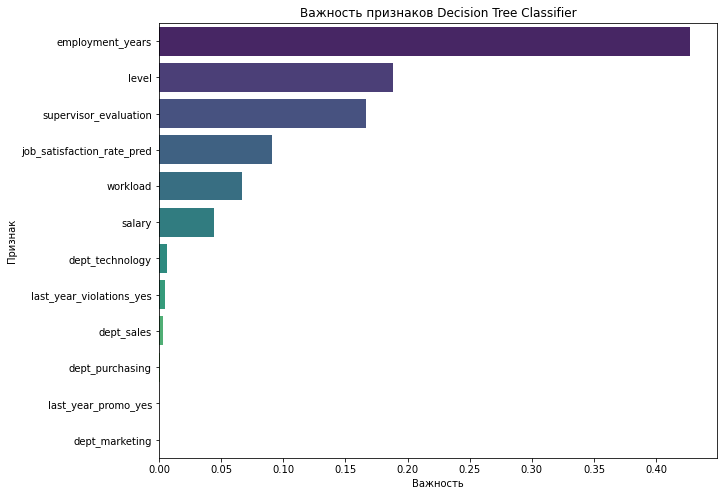

Топ-10 важных признаков:


,Feature,Importance
9,employment_years,0.427536
6,level,0.188538
10,supervisor_evaluation,0.166638
11,job_satisfaction_rate_pred,0.091312
7,workload,0.066526
8,salary,0.044559
5,dept_technology,0.006147
0,last_year_violations_yes,0.004497
4,dept_sales,0.003020
3,dept_purchasing,0.001227


In [63]:
# Извлекаем лучшую модель
best_pipeline = randomized_search.best_estimator_

# 1. Получаем имена признаков после всех преобразований
# Достаем препроцессор из пайплайна
preprocessor = best_pipeline.named_steps['preprocessor']
# Для OneHotEncoder
ohe_processor = preprocessor.named_transformers_['ohe']
ohe_features = ohe_processor.named_steps['ohe'].get_feature_names_out(ohe_columns)
# Для OrdinalEncoder (остаются с исходными именами)
ord_features = ord_columns.copy()
# Для числовых признаков (остаются с исходными именами)
num_features = num_columns.copy()
# Собираем все имена признаков
all_feature_names = np.concatenate([ohe_features, ord_features, num_features])
# 2. Извлекаем важность признаков
dt_model = best_pipeline.named_steps['models']
feature_importances = dt_model.feature_importances_
# 3. Создаем DataFrame для визуализации
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)
# 4. Визуализация
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Важность признаков Decision Tree Classifier')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.show()
# 5. Вывод данных
print("Топ-10 важных признаков:")
display(importance_df.head(10))

Мы видим, что для нашей модели наиболее важным оказался признак level и employment_years, а вот признаки с повышением сотрудника, нарушением трудового договора и отделом похоже мало влияют на нашу модель. Попробуем убрать их и посмотрим, изменится ли результат метрики.

In [64]:
X_train2 = X_train_1.drop(columns=['dept', 'last_year_promo', 'last_year_violations'])
X_test2 = X_test_1_.drop(columns=['dept', 'last_year_promo', 'last_year_violations'])
X_train2.shape, X_test2.shape

((2587, 6), (2000, 6))

Теперь обновим списки признаков и пайплайн

In [65]:
ohe_columns = []  # если все признаки OHE были удалены
ord_columns = ['level', 'workload']  # оставляем только нужные
num_columns = ['salary', 'employment_years', 'supervisor_evaluation', 'job_satisfaction_rate_pred']

In [66]:
def updated_pipe(ord_columns, num_columns):
    ord_pipe = Pipeline([
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(
            categories=[ 
                ['junior', 'middle', 'senior'],
                ['low', 'medium', 'high'],
            ], 
            handle_unknown='use_encoded_value', 
            unknown_value=np.nan
        )),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ])    

    data_preprocessor = ColumnTransformer([
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], remainder='passthrough')

    return Pipeline([
        ('preprocessor', data_preprocessor),
        ('model', DecisionTreeClassifier(
            max_depth=5, 
            max_features=7,
            random_state=42)
        )
    ])

Обработаем признаки

In [67]:
pipe_final = updated_pipe(ord_columns, num_columns)

Обучим модель

In [68]:
pipe_final.fit(X_train2, y_train_1)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'senior'],
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'high']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('num', StandardScaler(),
                                                  ['salary', 'employment_years',
                                                   'supervisor_evaluation',
                                                   'job_satisfaction_rate_pred'])])),
                ('model',
                 DecisionTreeClassifier(max_depth=5, max_features=7,
                                        random_state=42))])

Проверим на тестовой выборке и вычислим метрику roc-auc score

In [69]:
y_pred_proba = pipe_final.predict_proba(X_test2)[:, 1]
roc_auc = roc_auc_score(y_test_1_, y_pred_proba)
print(f"ROC-AUC score: {roc_auc:.4f}")

ROC-AUC score: 0.9195


**Вывод:**
После удаления признаков, модель стала работать лучше, теперь ее roc-auc score - 0.9195

#### Вопрос к ревьюверу
Привет,честно говоря не понимаю как правильно написать код, так, чтобы модель можно было построить без этих признаков, абсолютно понимаю, что модель должна стать лучше, но как это сделать идей ноль,можно пожалуйста подсказку:)


**Вывод:**
Обучили модель, наилучшей оказалась модель дерева решений, с параметрами max_depth=4, max_features=5.
Метрика лучшей модели на тренировочной выборке: 0.9054018761903029, а на тестовой 0.9057221596633674
Модель готова к использованию

## **Общий вывод**

В ходе проекта были решены 2 задачи, а также были сделаны следующие шаги по каждой из них:
* Задача 1
    * Загрузили данные
        * Датафрейм train:
            * Состоит из 4000 строк и 10 столбцов
            * Явные дубликаты отсутсвуют
            * **Присутствуют пропуски в столбцах dept,level**
            * **Тип данных в столбце job_satisfaction_rate стоит изменить на float64**
        * Датафрейм X_test:
            * Состоит из 2000 строк и 9 столбцов
            * Явные дубликаты отсутствуют
            * С типами данных все в порядке
            * **Присутствуют пропуски в столбцах dept,level**
        * Датафрейм y_test:
            * Состоит из 2000 строк и 2 столбцов
            * Явные дубликаты отсутствуют
            * Пропуски отсутствуют
            * **Тип данных в столбце job_satisfaction_rate необходимо поменять на float64**
    * Выполнили предобработку данных
        * Изменили тип данных для столбца job_satisfaction_rate датафреймов train и X_test
        * Проверили данные на неявные дубликаты, их не оказалось
        * Оставили пропуски, приняли решения,что работать с ними будем на этапе подготовки данных
        * Изменили sinior на senior в столбце level
    * Провели исследовательский анализ данных
        * Датасет train и датасет X_test и y_test
            *Непрерывные колличественные признаки:
                * salary - В данном признаке, распределение не особо выглядит равномерным, имеется сдвиг в левую сторону, так же есть выбросы , также можно заметить что данные в тренировочном и тестовом датафрейме разные по масштабу, следует учесть при подготовке данных
                * job_satisfaction_rate - В датафреймах train и y_test также распределение немного не похоже на нормальное, имеется сдвиг в правую сторону, выбросы отсутствуют, но при этом также заметен разный масштаб,стоит учесть при подготовке данных.
            * Дискретные или прерывные колличественные признаки:
                * employment_years - В датафреймах train и X_test, данные имеют не равномерное распределение, большинство сотрудников имеют стаж работы год, причем выбросов в данных нет, также заметен опять разный масштаб, стоит учесть при подготовке данных
                * supervisor_evaluation - В датафреймах train и X_test преобладают сотрудники чья работа была оценена на 3 и 4 балла,данные выбросов не имеют, также наблюдается разность масштаба в датафреймах,учтем
            * Категориальные признаки:
                * dept
                * level
                * workload
                * last_year_promo
                * last_year_violations
            * Анализ диаграмм показывает, что в компании наибольшее количество сотрудников работает в отделе продаж. Что касается уровней должности, то большинство сотрудников занимают позиции junior и middle. По уровню загруженности наибольшее количество работников имеет среднюю загруженность. Лишь 3% сотрудников получили повышение, в то время как 14% столкнулись с нарушениями трудового договора. Важно отметить, что распределение данных в тренировочной и тестовой выборках практически совпадает.
    * Провели корреляционный анализ данных
        *В матрице корреляции видим, что целевой признак значительно коррелирует с тем,нарушал ли сотрудник трудовой договор за последний год,  оценки качества работы сотрудника, которую дал руководитель и длительностью работы в компании,утечки целевого признака нет. Мультиколлинеарность отсутствует
    * Подготовили данные
        *Подготовили данные, для обучения модели, использовали пайплайны,кодировали, масштабировали, обработка пропусков,данные готовы для использования с моделью
    * Обучили модель
        * Результат метрики на тестовых данных, удовлетворительный - 14.8, можно использовать модель для дальнейших действий.
    * Лучшей оказалась модель дерева решений с гиперпараметрами: max_depth=10, max_features=10,min_samples_leaf=3, random_state=42
* Задача 2
    * Загрузили данные
        * Датафрейм train_1:
            * Состоит из 4000 строк и 10 столбцов
            * Явные дубликаты отсутствуют
            * Пропуски отсутствуют
            * С названиями столбцов все в порядке
            * C типами данных все в порядке
        * Датафрейм y_test_1:
            * Состоит из 2000 строк и 2 столбцов
            * Явные дубликаты отсутствуют
            * Пропуски отсутствуют
            * С названиями столбцов все в порядке
            * Типы данных в норме
    * Выполнили предобработку данных
        * Заменили грамматическую ошибку, больше никаких действий не делали, так как данные похожи на те же, что и в задании 1
    * Провели исследовательский анализ данных
        * Провели исследовательский анализ данных: общий портрет уволенного сотрудника: Работник,не загруженный работой, junior, имеющий низкую зарплату,чью работу не особо хорошо оценивает руководитель и имеющий стаж 1 год - типичный начинающий специалист
        * Утверждение подтвердилось, признак удовлетворенности сотрудника имеет зависимость с признаком уволенности, коэффицент корреляции равен 0.61, для дальнейшего обучения модели, необходимо учитывать этот признак.
        * Добавили новый признак в тестовую и тренировочную выборки
    * Подготовили данные
        * Обработали данные,закодировали, масштабировали, разобрались с обработкой пропусков, а также отчистили данные от дубликатов, теперь данные готовы к обучению на них
    * Обучили модель
        * Обучили модель, наилучшей оказалась модель дерева решений, с параметрами max_depth=5, max_features=7.
        * Метрика лучшей модели на тренировочной выборке: 0.9045496161995994, а на тестовой 0.912494567257354
        * Просмотрели значимость признаков и удалили: повышение сотрудника, нарушение трудового договора и отдел
        * Улучшили качество модели до 0.9195
Рекомендации для бизнеса по снижению уровня увольнений
    
    В процессе анализа текущей ситуации в команде, мы пришли к выводу, что для снижения уровня текучести кадров и повышения общей удовлетворенности сотрудников работой необходимо предпринять ряд мер:

Во-первых, важно регулярно отслеживать уровень удовлетворенности сотрудников. Это можно сделать с помощью анонимных опросов, индивидуальных бесед и обратной связи. Понимание потребностей и ожиданий сотрудников поможет создать более комфортную и продуктивную рабочую атмосферу.

Во-вторых, стоит обратить внимание на процесс карьерного роста внутри компании. Быстрый переход сотрудников из разряда junior в разряд medium не только повысит их мотивацию, но и укрепит их приверженность компании. Можно разработать четкие критерии и программы обучения, которые помогут сотрудникам быстрее развиваться и осваивать новые навыки.

Кроме того, увеличение объема работы для сотрудников, соответствующее их уровню квалификации, также может сыграть важную роль. Более высокая загрузка позволит не только повысить уровень заработной платы, но и даст возможность сотрудникам проявить свои способности и внести больший вклад в развитие компании. Это, в свою очередь, создаст атмосферу вовлеченности и ответственности.

Таким образом, комплексный подход к управлению человеческими ресурсами, включающий в себя мониторинг удовлетворенности, поддержку карьерного роста и оптимизацию рабочей нагрузки, поможет создать более стабильную и продуктивную команду.
